In [1]:
from datetime import datetime
from time import time
from csv import DictReader
from math import exp, log, sqrt
from random import random
import pickle
import os
import pandas as pd
import numpy as np

In [49]:
os.chdir('/Users/Dam/Desktop')

In [93]:
# A, paths
train='train_sample_df_million.csv'
test='test_sample_df_million.csv'
submission = 'ftrlsub.csv'  # path of to be outputted submission file

In [89]:
# B, model
beta = 1. # smoothing parameter for adaptive learning rate
L2 = 0. # L1 regularization, larger value means more regularized
interaction = False

In [81]:
# param_grid = {
#     'lambda_1': [round(elem, 4) for elem in list(np.logspace(-3,0,5))],
#     'alpha': [round(elem, 4) for elem in list(np.logspace(np.log10(0.005), np.log10(1), base = 10, num = 5))]
# }     

# param_grid

{'alpha': [0.005, 0.0188, 0.0707, 0.2659, 1.0],
 'lambda_1': [0.001, 0.0056, 0.0316, 0.1778, 1.0]}

In [96]:
param_grid = {
    'lambda_1': [round(elem, 4) for elem in [0.01, 0.25, 0.5, 0.75, 1]],
    'alpha': [round(elem, 4) for elem in [0.01, 0.25, 0.5, 0.75, 1]]
}     

param_grid

{'alpha': [0.01, 0.25, 0.5, 0.75, 1], 'lambda_1': [0.01, 0.25, 0.5, 0.75, 1]}

In [105]:
# C, feature/hash trick
D = 2 ** 24             # number of weights to use
                        # 우리 데이터의 경우 : (OHE 만들어 놨다는 가정하에)변수의 개수
# D, training/validation
epoch = 1       # learn training data for N passes
holdafter = None   # data after date N (exclusive) are used as validation
holdout = 7  # use every 8 training instance for holdout validation

In [106]:
def logloss(p, y):
    ''' FUNCTION: Bounded logloss

        INPUT:
            p: our prediction
            y: real answer

        OUTPUT:
            logarithmic loss of p given y
    '''
    p = max(min(p, 1. - 10e-15), 10e-15)
    return -log(p) if y == 1. else -log(1. - p)

In [107]:
# AUC calculator

def tied_rank(x):
    """
    Computes the tied rank of elements in x.
    This function computes the tied rank of elements in x.
    Parameters
    ----------
    x : list of numbers, numpy array
    Returns
    -------
    score : list of numbers
            The tied rank f each element in x
    """
    sorted_x = sorted(zip(x,range(len(x))))
    r = [0 for k in x]
    cur_val = sorted_x[0][0]
    last_rank = 0
    for i in range(len(sorted_x)):
        if cur_val != sorted_x[i][0]:
            cur_val = sorted_x[i][0]
            for j in range(last_rank, i): 
                r[sorted_x[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_x)-1:
            for j in range(last_rank, i+1): 
                r[sorted_x[j][1]] = float(last_rank+i+2)/2.0
    return r

def auc(actual, posterior):
    """
    Computes the area under the receiver-operater characteristic (AUC)
    This function computes the AUC error metric for binary classification.
    Parameters
    ----------
    actual : list of binary numbers, numpy array
             The ground truth value
    posterior : same type as actual
                Defines a ranking on the binary numbers, from most likely to
                be positive to least likely to be positive.
    Returns
    -------
    score : double
            The mean squared error between actual and posterior
    """
    r = tied_rank(posterior)
    num_positive = len([0 for x in actual if x==1])
    num_negative = len(actual)-num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if actual[i]==1])
    auc = ((sum_positive - num_positive*(num_positive+1)/2.0) /
           (num_negative*num_positive))
    return auc
##############################################################################

In [108]:
lst = []
for lam in param_grid['lambda_1']:
    for alp in param_grid['alpha']:
        class ftrl_proximal(object):
            def __init__(self, alp, beta, lam, L2, D, interaction):
                # parameters
                self.alp = alp
                self.beta = beta
                self.lam = lam
                self.L2 = L2

                # feature related parameters
                self.D = D
                self.interaction = interaction

                # model
                # n: squared sum of past gradients
                # z: weights
                # w: lazy weights
                self.n = [0.] * D


                self.z = [random() for k in range(D)]#[0.] * D
                self.w = {}

            def _indices(self, x):
                ''' A helper generator that yields the indices in x

                    The purpose of this generator is to make the following
                    code a bit cleaner when doing feature interaction.
                '''

                # first yield index of the bias term
                yield 0

                # then yield the normal indices
                for index in x:  # hash 처리 된 x값
                    yield index


            def predict(self, x):
                ''' Get probability estimation on x

                    INPUT:
                        x: features

                    OUTPUT:
                        probability of p(y = 1 | x; w)
                '''

                # parameters
                alp = self.alp
                beta = self.beta
                lam = self.lam
                L2 = self.L2

                # model
                n = self.n
                z = self.z
                w = {}

                # wTx is the inner product of w and x
                wTx = 0.
                for i in self._indices(x):  # 인덱스 존재하는 값만 w를 계산
                                            # 우리의 경우 nonzero x를 가져오면 됨
                    sign = -1. if z[i] < 0 else 1.  # get sign of z[i]

                    # build w on the fly using z and n, hence the name - lazy weights
                    # we are doing this at prediction instead of update time is because
                    # this allows us for not storing the complete w
                    if sign * z[i] <= lam:
                        # w[i] vanishes due to L1 regularization
                        w[i] = 0.
                    else:
                        # apply prediction time L1, L2 regularization to z and get w
                        w[i] = (sign * lam - z[i]) / ((beta + sqrt(n[i])) / alp + L2)

                    wTx += w[i]

                # cache the current w for update stage
                self.w = w

                # bounded sigmoid function, this is the probability estimation
                return 1. / (1. + exp(-max(min(wTx, 35.), -35.)))

            def update(self, x, p, y):
                ''' Update model using x, p, y

                    INPUT:
                        x: feature, a list of indices
                        p: click probability prediction of our model
                        y: answer

                    MODIFIES:
                        self.n: increase by squared gradient
                        self.z: weights
                '''

                # parameter
                alp = self.alp

                # model
                n = self.n
                z = self.z
                w = self.w

                # gradient under logloss
                g = p - y

                # update z and n
                for i in self._indices(x):
                    sigma = (sqrt(n[i] + g * g) - sqrt(n[i])) / alp
                    z[i] += g - sigma * w[i]
                    n[i] += g * g

        def data(path, D):

                    for t, row in enumerate(DictReader(open(path), delimiter=',')):
                    
                        try:
                            display_id = row['display_id']
                            ad_id = row['ad_id']
                            timestamp_event = row['timestamp_event']
                            is_leak = row['is_leak']
                            day_event = row['day_event']

                            del row['display_id']
                            del row['ad_id']
                            del row['timestamp_event']
                            del row['is_leak']
                            del row['day_event']

                        except:
                            pass
                        # process clicks
                        y = 0.
                        target='label'#'IsClick' 
                        if target in row:
                            if row[target] == '1':
                                y = 1.
                            del row[target]

                        # extract date

                        # turn hour really into hour, it was originally YYMMDDHH

                        # build x
                        x = []
                        for key in row:
                            value = row[key]

                            # one-hot encode everything with hash trick
                            index = abs(hash(key + '_' + value)) % D
                            x.append(index)

                        yield t, display_id, ad_id,  x, y

        # ##############################################################################
        # start training #############################################################
        ##############################################################################

        start = datetime.now()

        # initialize ourselves a learner
        learner = ftrl_proximal(alp, beta, lam, L2, D, interaction)

        # start training
        print('Start Training...')
 
        for e in range(epoch):

            loss_train = 0.
            loss_valid = 0.
            loss_valid_temp = 0.
            count = 0
            count_train = 0.
            count_valid = 0.
            predlist = []
            targetlist = []

            for t, display_id, ad_id, x, y in data(train, D):  # data is a generator
                
                count += 1

                if count % holdout == 0:
                    p = learner.predict(x)
                    loss_valid += logloss(p, y)
                    loss_valid_temp = logloss(p, y)
                    count_valid += 1
                    predlist.append(p)
                    targetlist.append(y)
                    
                else:
                    p = learner.predict(x)
                    loss_train += logloss(p, y)
                    count_train += 1
                    
                    learner.update(x, p, y)
                 
                if count % 200000 == 0:
                    print ('time_used:%s\tepoch: %-4drows:%d\tt_logloss:%f\tv_logloss:%f\tv_auc:%f' %\
                    (datetime.now() - start, e, count, loss_train/count_train, loss_valid/count_valid, \
                    auc(targetlist, predlist)))
                    
            print('*lambda is', str(lam), 'alpha is', str(alp), ' => validation logloss: %f' % (loss_valid/count_valid))
            lst.append([loss_valid/count_valid, [lam, alp]])
            
df = pd.DataFrame(lst, columns=cols)
df = df.sort_values('logloss')

print('**All Done!: Selected top 3 parameter sets are:')
print('='*100)

print(df[:3])

Start Training...
time_used:0:00:20.525229	epoch: 0   rows:200000	t_logloss:0.471262	v_logloss:0.471071	v_auc:0.663577
time_used:0:00:40.091043	epoch: 0   rows:400000	t_logloss:0.465601	v_logloss:0.463155	v_auc:0.680553
time_used:0:01:00.001824	epoch: 0   rows:600000	t_logloss:0.464259	v_logloss:0.464109	v_auc:0.685002
time_used:0:01:19.148052	epoch: 0   rows:800000	t_logloss:0.461423	v_logloss:0.461830	v_auc:0.689774
time_used:0:01:33.923818	epoch: 0   rows:1000000	t_logloss:0.459790	v_logloss:0.459237	v_auc:0.691226
*lambda is 0.01 alpha is 0.01  => validation logloss: 0.459286
Start Training...
time_used:0:00:23.036242	epoch: 0   rows:200000	t_logloss:0.459673	v_logloss:0.458750	v_auc:0.683963
time_used:0:00:42.506951	epoch: 0   rows:400000	t_logloss:0.452958	v_logloss:0.449971	v_auc:0.698558
time_used:0:00:59.732017	epoch: 0   rows:600000	t_logloss:0.452025	v_logloss:0.452124	v_auc:0.701377
time_used:0:01:19.797882	epoch: 0   rows:800000	t_logloss:0.449476	v_logloss:0.450106	v_auc:

Start Training...
time_used:0:00:28.019395	epoch: 0   rows:200000	t_logloss:0.512310	v_logloss:0.515665	v_auc:0.633996
time_used:0:00:57.657687	epoch: 0   rows:400000	t_logloss:0.494694	v_logloss:0.495151	v_auc:0.653281
time_used:0:01:15.894894	epoch: 0   rows:600000	t_logloss:0.488221	v_logloss:0.491545	v_auc:0.659737
time_used:0:01:34.369342	epoch: 0   rows:800000	t_logloss:0.482005	v_logloss:0.485508	v_auc:0.666067
time_used:0:01:51.598077	epoch: 0   rows:1000000	t_logloss:0.478088	v_logloss:0.480451	v_auc:0.669458
*lambda is 0.5 alpha is 1  => validation logloss: 0.480060
Start Training...
time_used:0:00:22.061783	epoch: 0   rows:200000	t_logloss:0.471990	v_logloss:0.471830	v_auc:0.659501
time_used:0:00:45.468253	epoch: 0   rows:400000	t_logloss:0.466226	v_logloss:0.463810	v_auc:0.677689
time_used:0:00:59.970679	epoch: 0   rows:600000	t_logloss:0.464818	v_logloss:0.464694	v_auc:0.682757
time_used:0:01:14.470718	epoch: 0   rows:800000	t_logloss:0.461930	v_logloss:0.462362	v_auc:0.68

In [109]:
df2 = pd.concat([df.logloss, pd.DataFrame(df.params.tolist(), columns = ['lambda1', 'alpha'])], axis = 1)

In [110]:
# logloss 순으로 정렬
pd.options.display.float_format = '{:.4f}'.format
df2.sort_values('logloss')

,logloss,lambda1,alpha
21,0.4470,0.7500,1.0000
16,0.4472,0.7500,0.7500
11,0.4475,0.5000,0.0100
6,0.4478,0.7500,0.5000
1,0.4481,0.7500,0.2500
22,0.4551,0.5000,1.0000
17,0.4561,0.5000,0.7500
12,0.4572,0.0100,0.5000
7,0.4586,0.5000,0.5000
0,0.4593,1.0000,0.2500


In [100]:
# library import
import mglearn
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar의 크기를 정하기 위한 축 library

# matplotlib 설정
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [111]:
df2 = df2.round(4)

In [112]:
# 차원 변형
log_loss = df2['logloss'].values.reshape(5, 5)

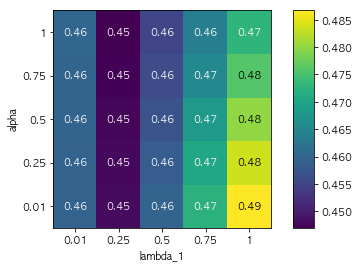

In [113]:
# 시각화
score_image = mglearn.tools.heatmap(log_loss, xlabel='lambda_1', 
                                    xticklabels=param_grid['lambda_1'],
                      ylabel='alpha', yticklabels=param_grid['alpha'])

ax = plt.gca() # GetCurrentAxis
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad='10%')
plt.colorbar(score_image, cax=cax)
plt.show()

In [23]:
with open(submission, 'w') as outfile:
    outfile.write('display_id,ad_id, prob\n')
    for t, display_id, ad_id, x, y in data(test, D):
        p = learner.predict(x)
        outfile.write('%s,%s,%s\n' % (display_id, ad_id, str(p)))